# Anomaly Detection HW - (Un)supervised Learning
#### Created by: Shaul Solomon

In this homework, we will try to explore ways to explore a "mostly" unlabeled dataset *within* a larger problem space.

### Motivation

You are a new data scientist joining a DS team that has already been working on a classification problem for a few weeks.

The dataset is coming from a field in which you have no background experience, and the other people on your team are worrisome of someone new joining their project.

Here is what you know so far:
1. The project is a classification problem to detect if a new instance belongs to one of 15 classes. However there is noise in the dataset and bad cases need to labeled and filtered out.
2. The company found a dude on Fiverr who said he was a domain expert and would charge only 5 cents per label (though he would only accept it in Bitcoin). After the project was done, the DS team discovered there was noise in the labeling, but by that time, Mr. Fiverr skipped town, burnt his fingerprints, and apparently was starting a new EFT startup ([Jesus Toast NFT](https://opensea.io/assets/ethereum/0x495f947276749ce646f68ac8c248420045cb7b5e/29379836586482566762011168218144394594657388904534917765071502304442530660353))in the Bahamas.
3. The company hired a Chilean startup to label the data, but it is very expensive and slow, and due to conflict in the region, the labeling has stopped. They have properly labeled all of the test data and around a quarter of the train dataset.
4. Your DS Team spent a lot of work on the classification model, and don't want you to change anything at all.

### Your Objective

In this homework, you will try three different methods, supervised and unsupervised, to try and filter out noisy obs from the dataset, in order to improve the classification model (Evaluation Metric - weighted F1 score).

You have been given clear instructions that you **can not**:
1. Change the features in the dataset (no feature selection or feature engineering).
2. Change anything w.r.t to the Classification model (RF Classifier) - not even the hyperparameters.

Beyond the homework itself, try your hand to see how good you can get the model simply by filtering out noise (in a sandbox with all the noise filtered - the model can theoretically get up to a F1 score of 98%).

Good Luck!

### Imports

In [2]:
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from collections import Counter
from sklearn.cluster import KMeans, DBSCAN

In [3]:
### Ignore all warnings - uncomment this out if you'd like not to see the warnings ###
# import warnings
# warnings.filterwarnings(action='ignore', category=UserWarning)

### Immutable Code

In [86]:
#### Immutable Code
class RFModel_544():
    def __init__(self, train_data, test_data, label = 'Class') -> None:
        self.model = None
        self.label = label

        #self.train_data = train_data.copy()
        self.train_data = train_data.sort_index().copy()
        self.test_data = test_data.copy()

        if 'Corrupted' in self.train_data.columns:
            self.train_data = self.train_data.drop('Corrupted', axis=1)        

    def fit(self):
        y_train = self.train_data[self.label]
        X_train = self.train_data.drop(self.label, axis=1)
    
        self.clf = RandomForestClassifier(random_state=44, n_estimators=5, max_depth=3)
        self.clf.fit(X_train, y_train)
        return self
    
    def predict(self):
        X_test = self.test_data.drop(self.label, axis=1)
        y_pred = self.clf.predict(X_test)
        return y_pred
    
    def evaluate(self):
        y_test = self.test_data[self.label].values
        y_pred = self.predict()
        f1 = f1_score(y_test, y_pred, average='weighted')
        return f1

In [87]:
def run_classification_544(train_data, test_data, label = 'Class', return_f1_score = False):
    model = RFModel_544(train_data, test_data, label)
    model.fit()
    f1 = model.evaluate()
    if return_f1_score:
        return np.round(f1*100,2)
    else:
        print(f'F1 Score (weighted): {np.round(f1*100,2)}%')

### Import Data

In [88]:
train_data = pd.read_csv('ad_data/train_data.csv', index_col=0)
test_data = pd.read_csv('ad_data/test_data.csv', index_col=0)

In [89]:
train_data.head(3)

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Feature_18,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Class,Corrupted
0,-4.442740,3.509633,-2.595045,5.625753,5.241519,-3.391638,-0.161169,-2.479898,4.678951,-0.096087,...,-1.322623,4.709249,0.870410,1.292379,1.001019,2.828160,3.314469,-2.083216,8,NaN
1,-4.913701,-3.472922,-0.711968,3.605206,-2.977909,-2.479564,1.661866,5.808457,3.522298,-5.740412,...,-3.559130,5.701702,-6.776739,4.780978,0.958094,-2.798584,-1.367130,0.887345,9,NaN
2,0.745200,2.064658,1.635380,-2.599492,-5.820311,-5.141749,0.626823,-0.901922,3.417227,4.113865,...,4.756362,1.337834,3.691216,1.652381,-3.740889,-2.653817,-3.550755,-1.934451,1,NaN


### Step 0 - Establish Baseline

In [90]:
run_classification_544(train_data, test_data, label='Class')

F1 Score (weighted): 88.3%


### Step 1 - EDA

There are two questions here just to make sure you understand the particulars of this dataset, but we recommend you do as much EDA as you want/need.

#### Q1.1 (2 points):
First, visualise the distribution of labels within train/test set. (it's about classes)
1. Are there imbalances?
2. Are there any labels that don't exist within the test set?

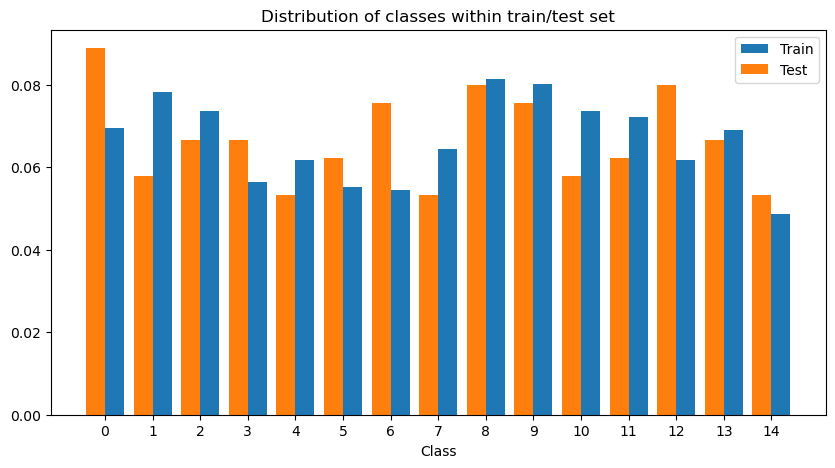

In [91]:
plt.figure(figsize=(10,5))

plt.bar(train_data['Class'].unique(), train_data['Class'].value_counts()/ train_data['Class'].count(), \
    align='edge', width=0.4, label='Train')
plt.bar(test_data['Class'].unique(), test_data['Class'].value_counts()/ test_data['Class'].count(), \
    align='edge', width=-0.4, label='Test')

plt.legend()
plt.xticks(train_data['Class'].unique())
plt.xlabel('Class')
plt.title("Distribution of classes within train/test set")
plt.show()

1. Classes aren't represented equally in the train and the test data set, but the imbalance doesn't seem crucial.
2. All classes which are existed in the train data set are represented in the test data set.

#### Q1.2 (2 points):
Look at the labeled data within the train set: (it's about 'Corrupted')
1. What percentage of the data has labels?
2. How is it divided between classes?

The percentage of the data has labels: 25.02%


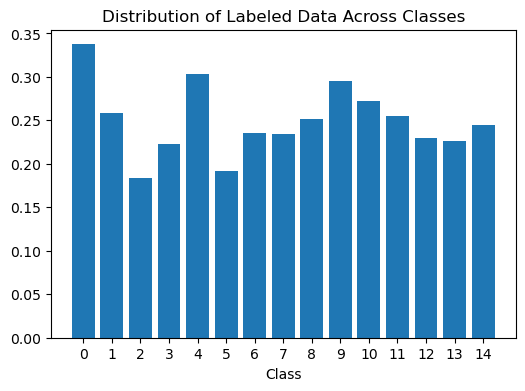

The maximum labeled values appears in 6 class and constitutes 33.73%
The minimum labeled values appears in 4 class and constitutes 18.37%


In [92]:
### Insert Code Here
# What percentage of the data has labels?
print('The percentage of the data has labels:', \
    f"{(train_data['Corrupted'].count() / len(train_data['Corrupted'])):.2%}")

# How it divided between classes?
lb_class = train_data[~train_data['Corrupted'].isna()].groupby('Class')['Class'].count() / train_data.groupby('Class')['Class'].count()

plt.figure(figsize=(6,4))

plt.bar(train_data['Class'].unique(), lb_class)

plt.xticks(train_data['Class'].unique())
plt.xlabel('Class')
plt.title("Distribution of Labeled Data Across Classes")
plt.show()

print(f'The maximum labeled values appears in {np.argmax(lb_class)} class and constitutes {lb_class.max():.2%}')
print(f'The minimum labeled values appears in {np.argmin(lb_class)} class and constitutes {lb_class.min():.2%}')

In [93]:
print(f"""The ratio of the corrupted labels among the all labels: \
    {(len(train_data[train_data['Corrupted']==1]) / len(train_data[~train_data['Corrupted'].isna()])):.2f}""")

The ratio of the corrupted labels among the all labels:     0.39


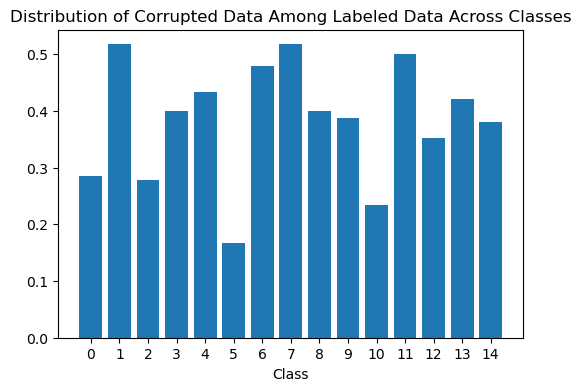

The maximum labeled values appears in 2 class and constitutes 51.72%
The minimum labeled values appears in 12 class and constitutes 16.67%


In [94]:
# How it divided between classes?
lb_class = train_data[train_data['Corrupted']==1].groupby('Class')['Class'].count() / train_data[~train_data['Corrupted'].isna()].groupby('Class')['Class'].count()

plt.figure(figsize=(6,4))

plt.bar(train_data['Class'].unique(), lb_class)

plt.xticks(train_data['Class'].unique())
plt.xlabel('Class')
plt.title("Distribution of Corrupted Data Among Labeled Data Across Classes")
plt.show()

print(f'The maximum labeled values appears in {np.argmax(lb_class)} class and constitutes {lb_class.max():.2%}')
print(f'The minimum labeled values appears in {np.argmin(lb_class)} class and constitutes {lb_class.min():.2%}')

#### Q1.3 (1 point):
Can we assume that this sample labeled dataset represents the true ratio of corrupted/not_corrupted within the larger data - why or why not - explain?

We discovered that only 25% of the entire dataset is labeled. This proportion is relatively small and may not accurately represents the true ratio of corrupted and non-corrupted data in the larger, unlabeled portion. Therefore we can not assume that this sample labeled dataset represents the true ratio.

### Step 2 - Supervised Learning

Even though we only have a subset of the data that has labels, perhaps it is enough to train a classifier to be able to distinguish between normal/corrupt instances?

#### Q2.1 (10 points)
Run a Proof of Concept (POC) - take only the cases where the data is labeled, and run a simple classifier (similar to the 544): <br> `model = RandomForestClassifier(random_state=44, n_estimators=5, max_depth=3)
` <br> see if we get a decent score on the classifier?

In [233]:
### Insert Code Here
model_rf = RandomForestClassifier(random_state=59, n_estimators=5, max_depth=3)

# chose only labeled data
train_data_wl = train_data[~train_data['Corrupted'].isna()].copy()

# split labeled data to train and test
X_train, X_test, y_train, y_test = train_test_split(train_data_wl.drop('Corrupted', axis=1), \
    train_data_wl['Corrupted'], test_size=0.2, random_state=71)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

print(f"F1 score for POC is {f1_score(y_test, y_pred_rf, average='weighted'):.3f}")

F1 score for POC is 0.895


The F1 score for POC is 0.895, which is decent. But let's give a look at the perfomance of the Classificaltion model by DS Team. 
At first let's get a F1 score with all labeled (in the column "Corrupted") train data, and the we will eliminate the noise and run the Classification model once again.

In [241]:
# run the Classification model for all labeled (in the column "Corrupted") training data 
run_classification_544(train_data_wl, test_data, label='Class') 

F1 Score (weighted): 60.2%


In [242]:
#reduce the noise and run the Classification model for not corrupted training data 
run_classification_544(train_data_wl[train_data_wl['Corrupted']!=1.0], test_data, label='Class') 

F1 Score (weighted): 59.75%


It seems pretty strange that after we eliminate the noise the Classification model performance reduced. It could indicate potential issues with the Classification model by DS team or its suitability to the data. Also it's possible that what is labeled as 'noise' might not be true noise, or the 'noise' could be providing some valuable information to the model. 

#### Q2.2 (15 Points)
Now that you have (hopefully) proven the POC: <br>
1. Retrain the classifier on all of the labeled data.
2. Run it on the unlabeled data.
3. See how it affects `run_classification_544` - you need to beat the baseline!

In [235]:
### Insert Code Here

# Retrain the classifier on all of the labeled data.
model_rf.fit(train_data_wl.drop('Corrupted', axis=1), train_data_wl['Corrupted'])

# Run it on the unlabeled data.
train_data_ul = train_data[train_data['Corrupted'].isna()].copy()

# predict labels
train_data_ul['Corrupted'] = model_rf.predict(train_data_ul.drop('Corrupted', axis=1))

# create df with labels
train_data_supervised = pd.concat([train_data_wl, train_data_ul])

# filter out corrupted data
train_data_supervised = train_data_supervised[train_data_supervised['Corrupted'] == 0]

In [236]:
run_classification_544(train_data_supervised, test_data, label='Class')

F1 Score (weighted): 80.52%


### Step 3 - Unsupervised method

While the supervised method was nice, perhaps we can beat it with using *all* the data to train an unsupervised method.

#### Q3.1 (10 points)
Use either IsolationForest or LocalOutlierFactor (or both) and train the model to predict outliers. <br>
The only hyper-parameter to play with at this stage is `contamination`. <br>
1. What is your default value for contamination and defend your initial hypothesis.
2. Look at the model's predictions - how much noise did it determine from the data? 
3. How well did the model do compared to the supervised/baseline? 

<u>1. What is your default value for contamination and defend your initial hypothesis.</u>

The default value for the contamination parameter is set to 0.39 based on the ratio of corrupted labels within the training dataset. The hypothesis is that the observed ratio of corrupted labels in the training set is indicative of the proportion of outliers within the entire dataset.

In [99]:
contamination_amount = 0.39
train_data_unsupervised = None

In [100]:
model_if = IsolationForest(contamination=contamination_amount, random_state=1)
train_data_if = train_data.drop(['Corrupted'], axis=1).copy()
model_if.fit(train_data_if)
 
predictions_if = model_if.predict(train_data_if) #[1 if x==-1 else 0 for x in model_if.predict(train_data_if)]
predictions_if_test = model_if.predict(test_data)

In [101]:
# 2. Look at the model's predictions - how much noise did it determine from the data? 
print(f"The ratio of the noise which the model determined from the training data is \
    {(len(predictions_if[predictions_if==-1]) / len(predictions_if)):.2f}")
print(f"The ratio of the noise which the model determined from the test data is \
    {(len(predictions_if_test[predictions_if_test==-1]) / len(predictions_if_test)):.2f}")

The ratio of the noise which the model determined from the training data is     0.39
The ratio of the noise which the model determined from the test data is     0.20


In [102]:
# filter train data
train_data_unsupervised = train_data_if[predictions_if == 1]

In [103]:
#How well did the model do compared to the supervised/baseline? 
run_classification_544(train_data_unsupervised, test_data, label='Class')

F1 Score (weighted): 74.07%


In [104]:
### Insert Explanation Here

#### Q3.2 (15 points)
1. Iterate through various contamination levels - `np.linspace(0.05, 0.5, 10)` and plot the lineplot of the f1_score.
2. Explain the lineplot that you see - does it give you confidence?
3. Which contamination gave the best results - explain possibly why? 

In [105]:
train_data_unsupervised_best = None

In [106]:
train_data_if = train_data_wl.drop(['Corrupted'], axis=1).copy()

dict_f1 = {}
for contamination_amnt in np.linspace(0.05, 0.5, 10):
    model_if = IsolationForest(contamination=contamination_amnt, random_state=44)
    model_if.fit(train_data_if)
    train_data_unsupervised = train_data_if[model_if.predict(train_data_if)==1]
    
    dict_f1[contamination_amnt] = run_classification_544(train_data_unsupervised, test_data, label='Class', return_f1_score = True)

### Get max F1 Score
max_f1 = max(dict_f1.values())
max_f1_contamination = [k for k, v in dict_f1.items() if v == max_f1][0]
print(f'Max F1 Score: {max_f1}% - Contamination: {max_f1_contamination}')

Max F1 Score: 73.45% - Contamination: 0.2


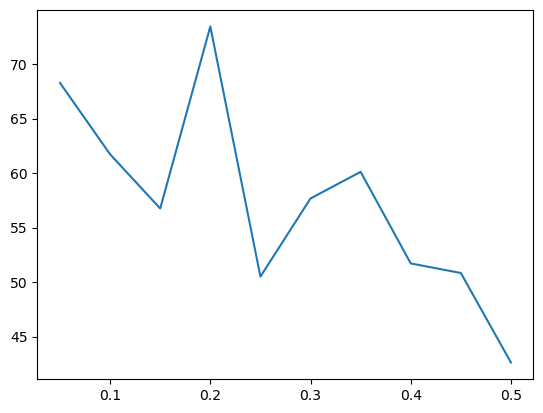

In [25]:
### elbow method
plt.plot(list(dict_f1.keys()), list(dict_f1.values()));

In [107]:
model_if = IsolationForest(contamination=0.2, random_state=44)
model_if.fit(train_data_if)
train_data_unsupervised_best = train_data_if[model_if.predict(train_data_if)==1]

In [108]:
run_classification_544(train_data_unsupervised_best, test_data, label='Class')

F1 Score (weighted): 73.45%


I expected the unsupervised to do better.
Perhaps what we should of done from the get-go is to visualise the data, both how the classes are spread out and their respective noise.

### Step 4 - Dimensionality Reduction (PCA)
#### Q4 (10 points)
1. Use PCA to visualise each of the data points and their respective.
2. What insight do we learn from the data that we can use to improve our models?

In [109]:
import plotly.express as px

In [110]:
def vis_PCA(df, label, shape):
    ### I recommend using plotly.express for this visualization
    # standardize the data
    scaler = StandardScaler(with_mean=True,with_std=True)
    scaler.fit(df.drop([label, shape], axis=1))
    df_sc = scaler.transform(df.drop([label, shape], axis=1))

    # pca
    pca = PCA(2)
    pca_df = pd.DataFrame(pca.fit_transform(df_sc))
    pca_df['label'] = df[label]
    pca_df['shape'] = df[shape].apply(lambda x: 'Corrupted' if x == 1 else 'Not corrupted')

    fig = px.scatter(pca_df, x=0, y=1, color='label', symbol='shape', \
        title='PCA Visualization of Classes and Corrupted Instances')
    fig.show()

### Insert Code Here


In [111]:
# visualization of the whole train_data
vis_PCA(train_data, 'Class', 'Corrupted')

In [112]:
# visualization of only labeled train_data
vis_PCA(train_data[~train_data['Corrupted'].isna()], 'Class', 'Corrupted')

In [113]:
#### Insert Explanation Here

### Step 5 - Clustering per Class

Another classic method for anomaly detection is by looking at each class individually, using clustering methodologies (KMeans, KNN, DBScan, etc.) to determine what is the normal data and what is noise.
#### Q5.1 (15 points)
Train a simple KNN/Kmeans/DBscan that just determines for each class in and out class

#### Q5.2 (10 points) 
For whichever model you used, use the labeled data to use reasonable hyperparameters.

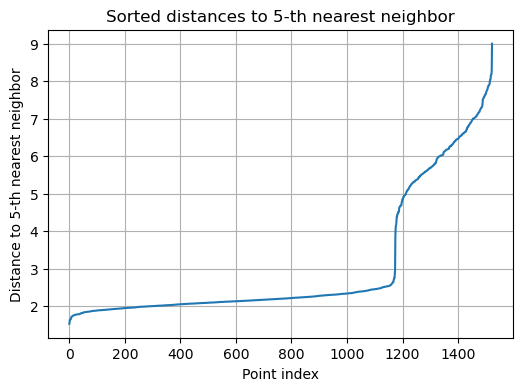

In [114]:
from sklearn.neighbors import NearestNeighbors

k=5
# Exclude the label and corrupted columns
X = train_data.drop(['Class', 'Corrupted'], axis=1)  

# Scaling the features
X_scaled = StandardScaler().fit_transform(X)  

# Fit the NearestNeighbors model
nearest_neighbors = NearestNeighbors(n_neighbors=k)
nearest_neighbors.fit(X_scaled)

# Find the k-nearest neighbors for each point (the first nearest neighbor is the point itself)
distances, indices = nearest_neighbors.kneighbors(X_scaled)

# Sort the distances to the k-th nearest neighbor (k-th column of the distances array)
kth_distances = distances[:, k-1]
kth_distances_sorted = np.sort(kth_distances)

# Plot the results
plt.figure(figsize=(6, 4))
plt.plot(kth_distances_sorted)
plt.xlabel('Point index')
plt.ylabel(f'Distance to {k}-th nearest neighbor')
plt.title(f'Sorted distances to {k}-th nearest neighbor')
plt.grid(True)
plt.show()


Based on the plot above we will use eps = 3

In [187]:
train_data_clustering = None
#nr = [] 

for c in train_data['Class'].unique():
    # prepare the data
    X_train = StandardScaler().fit_transform(train_data[train_data['Class']==c].drop(['Class', 'Corrupted'], axis=1))
    eps = 3.03

    model_dbs = DBSCAN(eps=eps, min_samples=5) #2*X_train.shape[1])
    model_dbs.fit(X_train)

    tmp_df = train_data[train_data['Class']==c].copy()
    tmp_df['Corrupted'] = model_dbs.labels_
    #nr.append(len(tmp_df[tmp_df['Corrupted']==-1]['Corrupted'])/ tmp_df.shape[0])
    #print(f"For class {c} the noise ratio: {nr[-1]}")
    
    if train_data_clustering is None:
        train_data_clustering = tmp_df.copy()
    else:
        train_data_clustering = pd.concat([train_data_clustering, tmp_df])

#print(f"The average noise ration is {np.mean(nr)}")

train_data_clustering = train_data_clustering[train_data_clustering['Corrupted'] != -1]

The average noise ratio in the dataset which we get after implementing DBSCAN algorithm on each class is 0.41, wich is relatively high. But taking into account the ratio of the corrupted data among all labeled data in the training data which is 0.39, we can assume that the noise ratio equal to 0.41 is acceptable.

In [188]:
run_classification_544(train_data_clustering, test_data, label='Class')

F1 Score (weighted): 85.71%


We got F1 score slightly higher than the baseline. To increase if we can evaluate and specify hyperparameters for each class separately.

### Step 6 - Review

#### Q6.1 (5 points)
In this situation we knew that there was no noise in the test dataset - if we didn't know that - is there anything we would have done better? Explain?

If there was potential noise in the test dataset, it would be prudent to focus on noise detection and removal unsupervised techniques, as we did for the train dataset.

#### Q6.2 (5 points)
If we chose to go with the unsupervised methods, what benefit could the labeling that did do help us?

The pre-existing labels will enable to validate and evaluate the model performance by comparing unsupervised outcomes with known labels. These labels also helpful with interpretability of the unsupervised model's results.

### BONUS - GO WILD (10 points)
Choose any of the methods above and do what you go to do to get a weighted f1 score above 93%

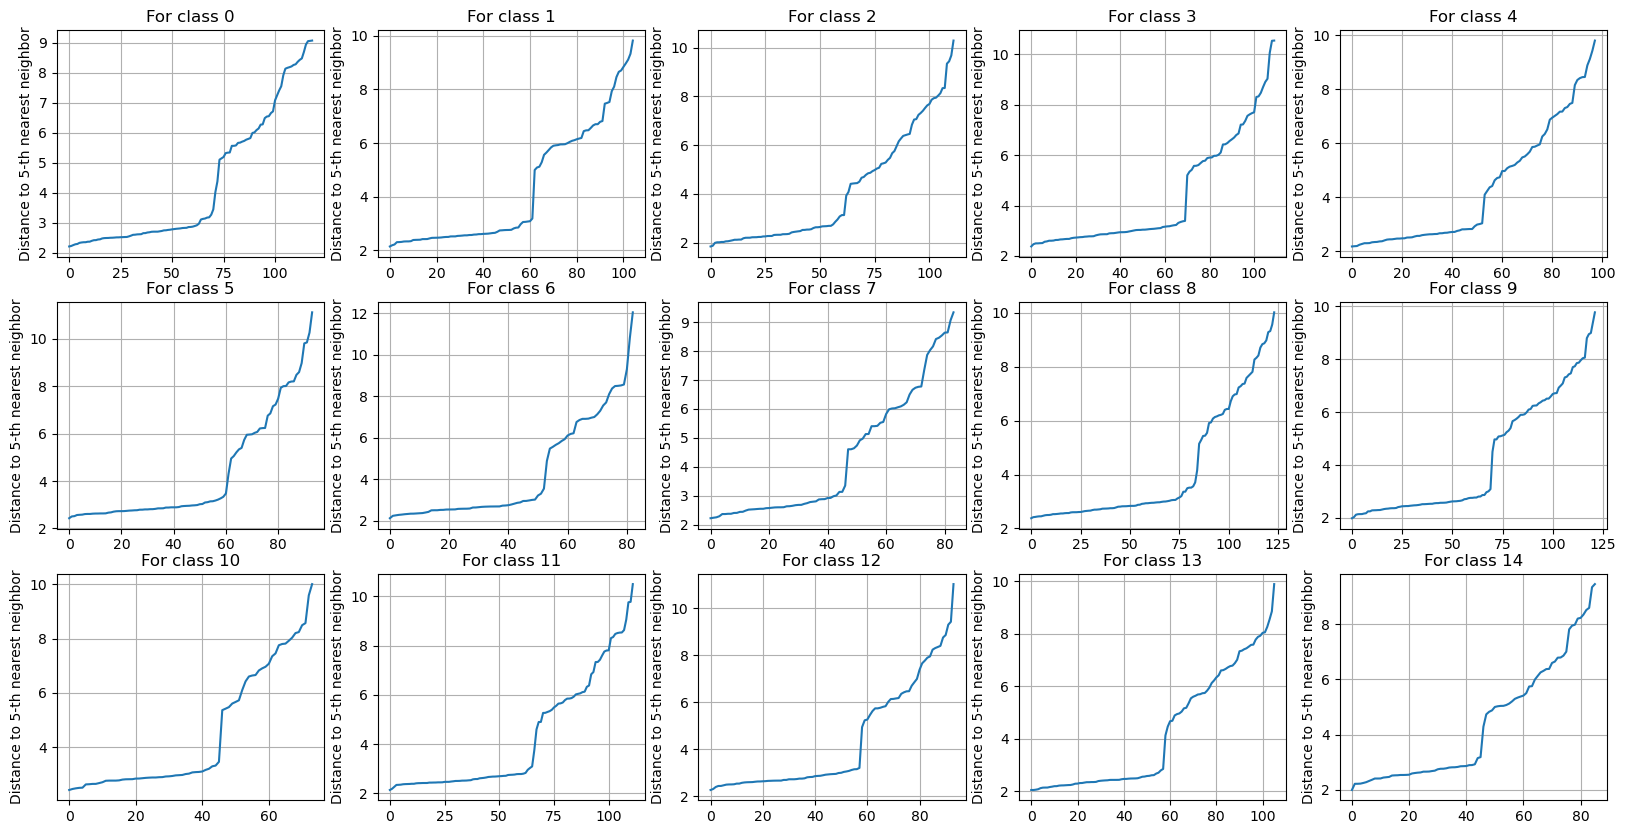

In [122]:
# let's use clustering per class, but tune hyperparametr for each class

plt.figure(figsize=(20,10))
i = 1

for c in np.sort(train_data['Class'].unique()):
    # Exclude the label and corrupted columns
    X = train_data[train_data['Class']==c].drop(['Class', 'Corrupted'], axis=1)  

    # Scaling the features
    X_scaled = StandardScaler().fit_transform(X)  

    # Fit the NearestNeighbors model
    nearest_neighbors = NearestNeighbors(n_neighbors=5)
    nearest_neighbors.fit(X_scaled)

    # Find the k-nearest neighbors for each point (the first nearest neighbor is the point itself)
    distances, indices = nearest_neighbors.kneighbors(X_scaled)

    # Sort the distances to the k-th nearest neighbor (k-th column of the distances array)
    kth_distances = distances[:, k-1]
    kth_distances_sorted = np.sort(kth_distances)

    # Plot the results
    plt.subplot(3, 5, i)
    plt.plot(kth_distances_sorted)
    plt.ylabel(f'Distance to {k}-th nearest neighbor')
    plt.title(f'For class {c}')
    plt.grid(True)
    i += 1
plt.show()

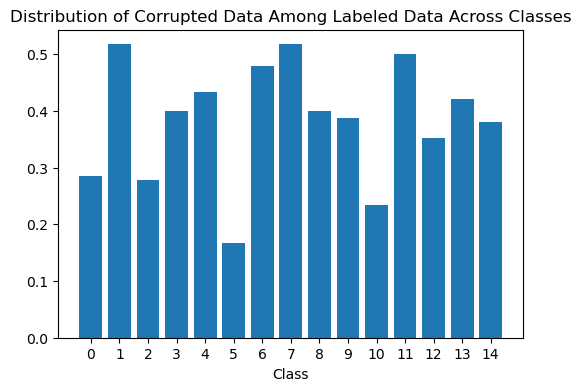

In [123]:
# How it divided between classes?
lb_class = train_data[train_data['Corrupted']==1].groupby('Class')['Class'].count() / train_data[~train_data['Corrupted'].isna()].groupby('Class')['Class'].count()

plt.figure(figsize=(6,4))

plt.bar(train_data['Class'].unique(), lb_class)

plt.xticks(train_data['Class'].unique())
plt.xlabel('Class')
plt.title("Distribution of Corrupted Data Among Labeled Data Across Classes")
plt.show()

In [189]:
c_dict = {0: 3.0, 1: 3.0, 2: 3.0, 3: 3.0, 4: 3.0, \
    5: 3.03, 6: 3.05, 7: 3.05, 8: 3.05, 9: 3.05,\
        10: 3.05, 11: 3.05, 12: 3.05, 13: 3.05, 14:3.05}

train_data_clustering_upd = None

for c, e in c_dict.items():
    # prepare the data
    X_train = StandardScaler().fit_transform(train_data[train_data['Class']==c].drop(['Class', 'Corrupted'], axis=1))

    model_dbs = DBSCAN(eps=e, min_samples=5) #2*X_train.shape[1])
    model_dbs.fit(X_train)

    tmp_df = train_data[train_data['Class']==c].copy()
    tmp_df['Corrupted'] = model_dbs.labels_
    
    if train_data_clustering_upd is None:
        train_data_clustering_upd = tmp_df.copy()
    else:
        train_data_clustering_upd = pd.concat([train_data_clustering_upd, tmp_df])

train_data_clustering_upd = train_data_clustering_upd[train_data_clustering_upd['Corrupted'] != -1]



In [190]:
run_classification_544(train_data_clustering_upd, test_data, label='Class')

F1 Score (weighted): 75.91%


In [191]:
# let's try SVM
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# chose only labeled data
train_data_wl = train_data[~train_data['Corrupted'].isna()].copy()

# split labeled data to train and test
X_train, X_test, y_train, y_test = train_test_split(train_data_wl.drop('Corrupted', axis=1), \
    train_data_wl['Corrupted'], test_size=0.25, random_state=44)

svm_pipeline_p = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel='poly', degree=2, C=6))])

svm_pipeline_p.fit(X_train, y_train)
y_pred_svm = svm_pipeline_p.predict(X_test)

print(f"F1 score for SVM model is {f1_score(y_test, y_pred_svm, average='weighted'):.3f}")

F1 score for SVM model is 0.868


In [103]:

# Retrain the classifier on all of the labeled data.
svm_pipeline_p.fit(train_data_wl.drop('Corrupted', axis=1), train_data_wl['Corrupted'])

# Run it on the unlabeled data.
train_data_ul = train_data[train_data['Corrupted'].isna()].copy()

# predict labels
train_data_ul['Corrupted'] = svm_pipeline_p.predict(train_data_ul.drop('Corrupted', axis=1))

# create df with labels
train_data_supervised_svm = pd.concat([train_data_wl, train_data_ul])

# filter out corrupted data
#train_data_supervised_svm = train_data_supervised_svm[train_data_supervised_svm['Corrupted'] != 1]

In [107]:
train_data[train_data['Corrupted']==1]['Class'].count()

149

In [108]:
train_data_supervised_svm[train_data_supervised_svm['Corrupted']==1]['Class'].count()

446

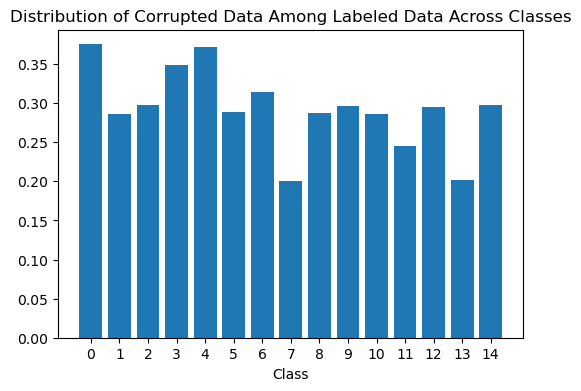

The maximum labeled values appears in 2 class and constitutes 37.50%
The minimum labeled values appears in 3 class and constitutes 20.00%


In [109]:
# How it divided between classes?
lb_class = train_data_supervised_svm[train_data_supervised_svm['Corrupted']==1].groupby('Class')['Class'].count() / train_data_supervised_svm.groupby('Class')['Class'].count()

plt.figure(figsize=(6,4))

plt.bar(train_data_supervised_svm['Class'].unique(), lb_class)

plt.xticks(train_data_supervised_svm['Class'].unique())
plt.xlabel('Class')
plt.title("Distribution of Corrupted Data Among Labeled Data Across Classes")
plt.show()

print(f'The maximum labeled values appears in {np.argmax(lb_class)} class and constitutes {lb_class.max():.2%}')
print(f'The minimum labeled values appears in {np.argmin(lb_class)} class and constitutes {lb_class.min():.2%}')

In [97]:
run_classification_544(train_data_supervised_svm, test_data, label='Class')

F1 Score (weighted): 87.51%


### Check statistical significance

In [77]:
from sklearn.utils import shuffle
from scipy import stats

In [78]:
def shuff_rf544(df):
    list_f1 = []
    for r in range(100):
        df_t = shuffle(df, random_state=r)
        list_f1.append(run_classification_544(df_t, test_data, label = 'Class', return_f1_score = True))
    return list_f1

In [79]:
base_l_f1 = shuff_rf544(train_data)


In [81]:
clust_l_f1 = shuff_rf544(train_data_clustering)

In [85]:
min(clust_l_f1)

70.43

In [82]:
stats.ttest_rel(base_l_f1, clust_l_f1).pvalue

0.4862986367736585

In [83]:
stats.ttest_ind(base_l_f1, clust_l_f1).pvalue

0.4643103481094072